β-globin locus fragments contact freq in K562

In [1]:
import pandas as pd
import numpy as np
import math
import datatable as dt
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes("pastel") 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from sklearn.utils import resample
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [2]:
def LoadTables(filename, sepstr, usecols):
    dt_df = dt.fread(filename, sep=sepstr, header=True, columns=usecols, fill=True)
    df  = dt_df.to_pandas()
    del dt_df
    gc.collect()
    return(df)

# Filter
def FilterDF(VDF_DF, region, filter_Frag):
    ## region filter
    print("Befor filter : %d"%len(VDF_DF))
    Pchr = VDF_DF.chrom == region[0]
    Pregion = (VDF_DF.start >= region[1]) & (VDF_DF.end <= region[2])
    VDF_filter = VDF_DF.loc[ Pchr & Pregion , :]
    print("After Region Filter: %d"%len(VDF_filter) )
    ## fragment filter
    Fragmentcount = VDF_filter.groupby(by="read_name", as_index=True)["chrom"].count()
    VDF_filter = VDF_filter.set_index("read_name")
    VDF_filter["Fragnum"] = 0
    VDF_filter.loc[:, "Fragnum"] = Fragmentcount.loc[VDF_filter.index]
    VDF_filter = VDF_filter.loc[VDF_filter.Fragnum>=filter_Frag, :] 
    print("After Fragment number Filter: %d"%len(VDF_filter) )
    return (VDF_filter)

# Bins 
def BinsDF(df, binsize=1000):
    df = df.reset_index()
    df["pos"] = (df.start.values + df.end.values)/2
    df["pos"] = df["pos"].astype("int")
    df["bin"] =  ( df["pos"].values/binsize ).astype("int")
    return (df)

# Loading
def Loading(filename, region, filter_Frag, binsize, Total_reads_num):
    #filename = "/data1/ZJY/Pore-C/NA12878/NA12878_Rep6/vdFAnnotation/Merge_Align_Fragment_RvdF.csv"
    print("Loading %s"%filename)
    usecols = {"read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"}
    VDF_DF = LoadTables(filename, ",",  usecols)
    VDF_DF.columns = ["read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"]
    # reads number
    readNum = len(  list(  set(VDF_DF.read_name.to_list())   )  )
    Total_reads_num += readNum 
    print("Loading %d reads."%readNum)
    VDF_filter = FilterDF(VDF_DF, region, filter_Frag)
    del(VDF_DF)
    gc.collect()
    # Bin calculate
    bin_df = BinsDF(VDF_filter, binsize)
    del(VDF_filter)
    return(bin_df, Total_reads_num)

# Loading bed
def Loadingbed(filename, region,binsize):
    print("Loading %s"%filename)
    usecols = [True, True, True, True, True, True]
    bedDF = dt.fread(filename, sep="\t", header=False, columns=usecols, fill=True)
    bedDF  = bedDF.to_pandas()
    bedDF.columns = ["chrom","start","end","name","value","strand"]
    Pchr = bedDF.chrom == region[0]
    Pregion = (bedDF.start >= region[1]) & (bedDF.end <= region[2])
    bedDF = bedDF.loc[Pchr&Pregion,:]
    bedDF = BinsDF(bedDF, binsize)
    return(bedDF)

In [3]:
filter_Frag = 2
region = ["chr11",5100000,5500000]
binsize=1000
Total_reads_num = 0
filename = "/data1/ZJY/Pore-C/Analysis/K562/K562_merge/Merge_Align_Fragment_RvdF_3Reps.chr11.csv"
binVDF, Total_reads_num  = Loading(filename, region, filter_Frag, binsize, Total_reads_num)
print("Total reads : %d"%Total_reads_num)

Loading /data1/ZJY/Pore-C/Analysis/K562/K562_merge/Merge_Align_Fragment_RvdF_3Reps.chr11.csv
Loading 4072672 reads.
Befor filter : 15306838
After Region Filter: 47957
After Fragment number Filter: 33700
Total reads : 4072672


In [48]:
# filter 2
filter_Frag = 2
region = ["chr11",5190000,5300000]
binVDF1 = FilterDF(binVDF, region, filter_Frag)
binVDF1 = binVDF1.reset_index()
binVDF1 ["flength"] = binVDF1 ["read_end"] - binVDF1 ["read_start"]
binVDF1 = binVDF1.sort_values(by=["read_name", "bin", "flength"], ignore_index=True)
# Merge bin： 
mergebinVDF = binVDF1.groupby(["read_name","bin"], as_index=False).first()

Befor filter : 33700
After Region Filter: 10447
After Fragment number Filter: 8432


In [49]:
# loading beta-globin bed
bedfile="/data1/ZJY/Pore-C/Analysis/K562/beta_globin_gene_lcr_annotation.bed"
bedDF = Loadingbed(bedfile, region, binsize)
bedDF = bedDF.set_index("bin")
bedDF.loc[:,"length"] = bedDF.end.values - bedDF.start.values
bedDF

Loading /data1/ZJY/Pore-C/Analysis/K562/beta_globin_gene_lcr_annotation.bed


,index,chrom,start,end,name,value,strand,pos,length
bin,,,,,,,,,
5204,0,chr11,5204959,5204985,3'HS1,100,+,5204972,26
5226,1,chr11,5225464,5227071,HBB,100,+,5226267,1607
5233,2,chr11,5232838,5234483,HBD,100,+,5233660,1645
5249,3,chr11,5248269,5249857,HBG1,100,+,5249063,1588
5253,4,chr11,5253188,5254781,HBG2,100,+,5253984,1593
5269,5,chr11,5268345,5269945,HBE1,100,+,5269145,1600
5276,6,chr11,5275745,5276302,HS1,100,+,5276023,557
5280,7,chr11,5280548,5281017,HS2,100,+,5280782,469
5285,8,chr11,5284514,5286115,HS3,100,+,5285314,1601


In [50]:
def Findbins(mergebinVDF, matchbinlist, flankbins=0):
    #binmatch = list( set( bedDF.index.values ) )
    mergebinVDF["binfind"] = 0
    # fragment bin match 
    P = mergebinVDF.bin.isin( matchbinlist )
    mergebinVDF.loc[ P, "binfind"] = 1
    ## binfind 
    if flankbins != 0:
        for flankD in range(1, flankbins+1):
            leftbinmatch = [i-flankD for i in matchbinlist]
            lP = mergebinVDF.bin.isin(leftbinmatch) 
            mergebinVDF.loc[ lP, "binfind"] = 1
            mergebinVDF.loc[ lP, "bin"] = mergebinVDF.loc[ lP, "bin"].values + 1
            rightbinmatch = [i+flankD for i in matchbinlist]
            rP = mergebinVDF.bin.isin(rightbinmatch) 
            mergebinVDF.loc[ rP, "binfind"] = 1
            mergebinVDF.loc[ rP, "bin"] = mergebinVDF.loc[ rP, "bin"].values - 1
    print(mergebinVDF.binfind.sum())
    return( mergebinVDF )

In [51]:
# find binds
matchbinlist = bedDF.loc[bedDF.name.str.contains("HS")].index.values
mergebinVDF = Findbins(mergebinVDF, matchbinlist, 0)
fcount = mergebinVDF.loc[mergebinVDF.binfind>=0, :].groupby("read_name")["binfind"].sum()
f_reads = fcount[fcount>=0].index.to_list()
binVDF_filter = mergebinVDF.loc[mergebinVDF.read_name.isin(f_reads), : ]
#binVDF_filter.loc[binVDF_filter.binfind==1, :]

384


In [52]:
binVDF_filter.head(3)

,read_name,bin,read_start,read_end,strand,chrom,start,end,MapQual,LRvdF_pfix,Fragnum,pos,flength,binfind
0,00111a37-740f-4c4e-8b45-d4b6b1114cba,5225,4355,7432,-,chr11,5223492,5226594,57,True,2,5225043,3077,0
1,00111a37-740f-4c4e-8b45-d4b6b1114cba,5229,7606,8061,+,chr11,5228863,5229323,60,True,2,5229093,455,0
2,00167731-bab9-4f74-b1d9-eb390e20848c,5224,1843,6015,-,chr11,5222234,5226443,56,True,2,5224338,4172,0


In [53]:
## FragMatrix
readnames = f_reads 
#BinIds = list( set(binVDF_filter.loc[binVDF_filter.binfind==1, "bin"].to_list() ) )
BinIds = list( set(binVDF_filter.bin.to_list() ) )

FragMatrix = pd.DataFrame( np.zeros( [len(BinIds), len(readnames)], dtype=int ), 
                          index = BinIds,
                          columns = readnames)

binVDF_group = binVDF_filter.groupby("read_name")
for read_name, df in binVDF_group:
    #P = df.binfind==1
    #FragMatrix.loc[ df.loc[P,"bin"].values, read_name ] = 1
    bids = df["bin"].values
    FragMatrix.loc[ bids , read_name ] = 1
    

In [54]:
FragMatrix.head(10)

,00111a37-740f-4c4e-8b45-d4b6b1114cba,00167731-bab9-4f74-b1d9-eb390e20848c,001a7c5f-e352-45a6-932d-27809687441d,002bdbcd-0dd9-4a9b-aa0f-a94d85fb0ba5,00515c74-63c9-450c-ae07-094a053fd26a,005d090b-21d6-433b-a734-18eb5e5d3010,005edb9c-c37f-4121-95c0-b359684f9351,0060f518-45e8-4118-845f-e6650a03cedb,00772081-9e5a-4d0c-84e2-c0cd0c355e44,00cbb590-72f9-47eb-a2d9-e773707d3a47,...,ff3d05be-b27d-474a-b300-3c65aa2343e6,ff53fdbd-d787-4f0d-9105-188c60422388,ff5fe1d4-9673-471e-aed7-34e5fbb359c7,ff7c9dc4-f4bc-4477-8e53-2684630dffd8,ffad7673-0c95-40b1-b3cb-5d28bc02b3c4,ffb8f408-46e1-48e4-b912-e989d6b1a160,ffcb032e-5ad6-4026-9a8f-80d8296f42c1,ffd8fb4d-5f20-4e9c-873c-441ab14b6519,fff5c734-26d9-43b7-920b-2bd0921ef6b9,fff6d001-708f-4927-ac04-b01c2ff0369b
5190,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The number of clusters: 3


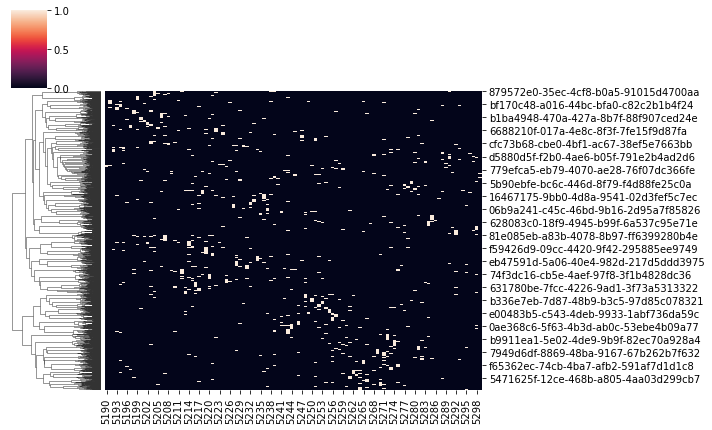

In [55]:
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
#plt.figure( dpi=200)
clusterDF = sns.clustermap(data=FragMatrix.T, metric="euclidean", method="ward", figsize=(10,6), col_cluster=False)
# export
## cluster branch tree order
dist_thred =11.5
Z = clusterDF.dendrogram_row.calculated_linkage
T = sch.fcluster(Z, t=dist_thred, criterion='distance')
print("The number of clusters: %d"%max(T) )

In [89]:
dist_thred =12
Z = clusterDF.dendrogram_row.calculated_linkage
T = sch.fcluster(Z, t=dist_thred, criterion='distance')
print("The number of clusters: %d"%max(T) )

The number of clusters: 2


In [90]:
## cluster leaves order index
reorder_idx = clusterDF.dendrogram_row.reordered_ind
read_names_order = FragMatrix.iloc[:, reorder_idx].columns.to_list()
## tree branch and leaves diction
Tdic = {}
#T = list(T)[::-1]
for i in range( len(T ) ):
    Tdic[ FragMatrix.columns[i] ] = T[i]
    
# hierarchy cluster_reads 
order_DF = binVDF_filter.set_index("read_name", drop=False).loc[read_names_order]
order_DF["Cluster"] = order_DF["read_name"].apply(lambda x: Tdic[x]) 
readorder = dict()
readidx = 0
for rn in read_names_order:
    readorder[rn] = readidx
    readidx += 1 
order_DF["read_order"] =  order_DF["read_name"].apply(lambda x: readorder[x] )
order_DF = order_DF.reset_index(drop=True)

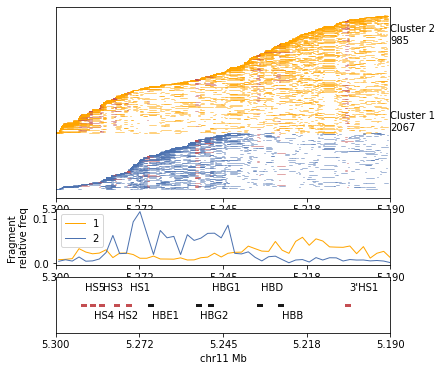

In [91]:
## Reads Cluster Figure
# Cluster reads numbers
def ClusterReads(clusterDF):
    groupDF = clusterDF.groupby("Cluster")
    
    cluster_list, readcount_list = [], []
    sumreads = 0
    readcount = 0
    for cluster, gdF in groupDF:
        cluster_list.append(cluster)
        readcount = len( list(set(gdF["read_name"].to_list()) ) )
        readcount_list.append(readcount)
        sumreads += readcount
    ratio_list = [ float(c)/sumreads for c in readcount_list ]
    cluster_readcount_df = pd.DataFrame({"Cluster":cluster_list,
                                    "readcount":readcount_list,
                                    "ratio":ratio_list})
    return(cluster_readcount_df) 
 
def FragmentDensity(clusterDF, Total_reads_num):
    # cluster read counts
    cluster_readcount_df  = ClusterReads(clusterDF)
    bincount_df = clusterDF.groupby(["Cluster", "bin"], as_index=False)["read_name"].count()
    bincount_df.columns = ["Cluster", "bin", "count"]
    bincount_df["ratio"] = 0.0
    allbins = list( range( bincount_df["bin"].min(),  bincount_df["bin"].max()+1 ) )
    ## bin ratio = bincount / Total_reads_num
    for i, rcount_row in cluster_readcount_df.iterrows():
        cluster_id,  readcount = rcount_row["Cluster"], rcount_row["readcount"]
        bincount_df.loc[bincount_df.Cluster==cluster_id, "ratio"] = bincount_df.loc[bincount_df.Cluster==cluster_id, "count"].values / Total_reads_num
        # bin without fragments
        bins = bincount_df.loc[bincount_df.Cluster==cluster_id, "bin"].to_list()
        sbins = [ b for b in allbins if b not in bins ]
        sbin_df = pd.DataFrame({"Cluster":len(sbins)*[int(cluster_id)],
                                "bin": sbins,
                               "count":0,
                               "ratio":0.0})
        bincount_df = pd.concat([bincount_df, sbin_df])
    bincount_df = bincount_df.sort_values(by=["Cluster", "bin"], ignore_index=True)
    bincount_df = bincount_df.astype({"Cluster":int, "bin":int})
    # relative ratio  group total reads
    bincount_df.loc[:, "relative_ratio"] = 0.0
    for Cluster, gdf in bincount_df.groupby("Cluster"):
        g_totalreads = Cluster_reads_count.loc[Cluster_reads_count.Cluster==Cluster, "Count"][Cluster]
        P = bincount_df.Cluster == Cluster
        bincount_df.loc[P, "relative_ratio"] = bincount_df.loc[P, "count"].values / g_totalreads
    
    return(bincount_df)

from scipy.interpolate import make_interp_spline
def smoothline(x_array, y_array, smbins=100):
    '''
    smooth lines
    input: x,y array
    output: x, smooth_y array
    bigger smbins makes  
    '''
    xi = np.linspace(x_array.min(),x_array.max(),smbins)
    y_smooth =  make_interp_spline(x_array, y_array)(xi)
    y_smooth[y_smooth<=0.0] = 0.0 # 校正负数；
    return(xi, y_smooth)


# Figure
plt.figure(figsize=(6,6))
sns.set_color_codes("deep")
colors = ["k", "orange", "b",  "g","c", "y", "k", "b", "y", "g","c", "k", "g"]

##  Cluster Figure 1
#read_order_df = order_DF.groupby(["Cluster","read_name"])["start"].min().reset_index() # sorted reads by the first fragment start
#read_order_df = read_order_df.sort_values(by=["Cluster","start"], ignore_index=True).reset_index().set_index("read_name")
read_order_df = order_DF.groupby(["Cluster","read_name"])["end"].max().reset_index() # sorted reads by the last fragment end
read_order_df = read_order_df.sort_values(by=["Cluster","end"], ignore_index=True, ascending=False).reset_index().set_index("read_name")

order_DF.loc[:, "FragY"] = read_order_df.loc[order_DF.read_name.to_list(), "index"].values
#colors = ["k","g", "b", "orange", "c", "purple",  "y", "navy"]
subsample = 1 # set subsample reads


ax1 = plt.subplot(5,1,(1,3), rasterized=True )
yn = 0
for cluster, gdf in order_DF.groupby(["Cluster", "read_name"]):
    yn = gdf["FragY"].values[0]
    if yn % subsample == 0:
        # grey line
        read_xs = [ gdf["bin"].min()*binsize, gdf["bin"].max()*binsize]
        ys = [yn, yn ]
        #plt.plot(read_xs, ys, c="lightgrey", linewidth=0.2) link lines
        # Fragments
        for indx, rowvalue in gdf.iterrows():
            yn = rowvalue["FragY"]
            sc = colors[cluster[0]]
            if rowvalue["bin"] in bedDF.index :
                sc = "r"
            else:
                sc = colors[cluster[0]]
            #start = rowvalue["bin"]*binsize - 0.5*binsize
            #end = rowvalue["bin"]*binsize + 0.5*binsize
            start, end = rowvalue["start"], rowvalue["end"]
            xs = [ start, end ]
            ys = [yn, yn ]
            # Fragment
            plt.plot(xs, ys, c=sc, linewidth=0.5)
plt.xticks([])
plt.yticks([])
## Cluster reads density
### Cluster reads number
Cluster_reads_count = order_DF.groupby(["read_name"])["Cluster"].first()
Cluster_reads_count = pd.DataFrame(Cluster_reads_count).reset_index()
Cluster_reads_count.columns = ["Read_name","Cluster"]
summary_count = Cluster_reads_count.Cluster.value_counts()
Cluster_reads_count = pd.DataFrame({"Cluster":summary_count.index,
                                   "Count":summary_count})
Cluster_reads_count.loc[:,"y"] = 0
for n, rowvalue in Cluster_reads_count.iterrows():
    cluster = rowvalue["Cluster"]
    cluster_count = rowvalue["Count"]
    ylist = set( order_DF.loc[order_DF.Cluster == cluster, "read_order"].to_list() )
    yvalue = sum( ylist )/len(ylist)
    Cluster_reads_count.loc[n]["y"] = yvalue
    plt.text(region[1], yvalue,  "Cluster %d\n%d"%(cluster, cluster_count), ha="left" )

    
ax2 = plt.subplot(5,1,4, sharex=ax1)
# Calculate Bin cluster read count and bin readcounts
cluster_readcount_df = ClusterReads(order_DF)
#print(cluster_readcount_df)
All_reads_num = Cluster_reads_count.Count.sum() 
BinDensity_df = FragmentDensity(order_DF,All_reads_num)
BinDensity_df.loc[:,"BinPos"] = BinDensity_df.loc[:,"bin"].values * binsize
# Plot Density
groupDF = BinDensity_df.groupby("Cluster")
Clist = []
for cluster, gdf in groupDF:
    cluster = int(cluster)
    x, y = gdf.BinPos.values, gdf.relative_ratio.values
    x, y = smoothline(x, y, 50)
    plt.plot(x, y, c=colors[cluster], linewidth=1)
    Clist.append(cluster)
plt.legend(Clist, loc='best')
plt.xlim([region[1], region[2]])
#plt.yscale('log')
#plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.ylabel("Fragment\nrelative freq")
plt.xticks([])


# Plot Gene Annotation
ax3 = plt.subplot(5,1,5, sharex=ax1)
#plt.show()
plt.xlim([region[1], region[2]])
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])



### xticks and save 
### xticks and save 
# xlim, xticks
plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )

# 反转 x轴, 子图 xticks
w = ax1.invert_xaxis()
ax1.set_xticklabels([])
w = ax2.invert_xaxis()
ax2.set_xticklabels([])
w = ax3.invert_xaxis()

ax3.set_xticks(Xtick)
ax3.set_xticklabels(Xtick_label)

Exportdir = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin"
os.system("mkdir -p %s"%Exportdir)
plt.savefig("%s/K562_clusters_%s_%d_%d.pdf"%(Exportdir, region[0], region[1], region[2]) )

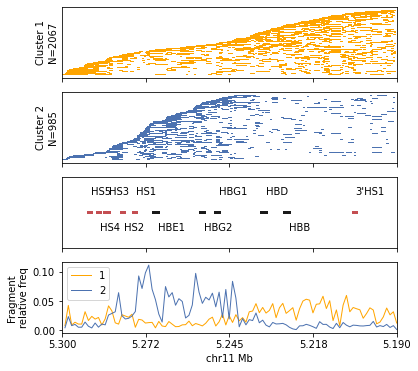

In [92]:
# Get Random sample reads
'''
1. Sample reads
2. Get reads with more than ? fragments
'''

def Reorder(df):
    '''
    Reorder read fragment by the first frag
    '''
    #re_df = df.groupby(["Cluster","read_name"])["start"].min().reset_index()
    #re_df = re_df.sort_values(by=["Cluster","start"], ignore_index=True).reset_index().set_index("read_name")
    re_df = df.groupby(["Cluster","read_name"])["end"].max().reset_index() # sorted reads by the last fragment end
    re_df = re_df.sort_values(by=["Cluster","end"], ignore_index=True, ascending=False).reset_index().set_index("read_name")

    df.loc[:, "FragY"] = re_df.loc[df.read_name.to_list(), "index"].values
    return(df)

from sklearn.utils import resample  

Samplerate = 0.5
Fragthred = 2
Pnum = order_DF.Fragnum >= Fragthred
SampleList = [] # Get sample reads
for cluster, gdf in order_DF.loc[Pnum].groupby(["Cluster"], as_index=False):
    Creads = list( set( gdf.read_name.to_list()  ) )  # cluter reads
    Samplenum = int( Samplerate * len(Creads) )
    Sreads = resample(Creads, n_samples=Samplenum,replace=1) # sample reads
    SampleList.append( gdf.loc[gdf.read_name.isin(Sreads) , :] )
Sampledf = pd.concat(SampleList) # Sample df
Sampledf = Reorder(Sampledf)    
 

## Cluster read numbers
Cluster_reads_count = order_DF.groupby(["read_name"])["Cluster"].first()
Cluster_reads_count = pd.DataFrame(Cluster_reads_count).reset_index()
Cluster_reads_count.columns = ["Read_name","Cluster"]
summary_count = Cluster_reads_count.Cluster.value_counts()
Cluster_reads_count = pd.DataFrame({"Cluster":summary_count.index,
                                   "Count":summary_count})    
    
# Cluster Figure 1
#plt.figure(figsize=(8,10) )
clusters = order_DF.Cluster.max()
FigRow, FigCol, N = cluster+2, 1, 1
plt.subplots(FigRow, FigCol, figsize=(6,6), sharex=True)
Axlist = []
subsample = 1
for cluster, cgdf in Sampledf.groupby("Cluster"):
    Axlist.append( plt.subplot(FigRow, FigCol, N)  )
    N += 1
    for read_name, gdf in cgdf.groupby("read_name"):
        yn = gdf["FragY"].values[0]
        if yn % subsample == 0:
            # grey line
            read_xs = [ gdf["bin"].min()*binsize, gdf["bin"].max()*binsize]
            ys = [yn, yn ]
            #plt.plot(read_xs, ys, c="lightgrey", linewidth=0.2) # fragment link lines
            # Fragments
            for indx, rowvalue in gdf.iterrows():
                yn = rowvalue["FragY"]
                sc = colors[cluster]
                start, end = rowvalue["start"], rowvalue["end"]
                xs = [ start, end ]
                ys = [yn, yn ]
                # Fragment
                plt.plot(xs, ys, c=sc, linewidth=1)
    plt.xticks([])
    plt.yticks([])
    readnum = summary_count[cluster]
    plt.ylabel( "Cluster %d\nN=%d"%(cluster, readnum) )


# HS Annotation
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    #xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    xs = [ gdf["start"], gdf["end"] ]
    if gdf["end"].values - gdf["start"].values <= 1000:
        xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize  ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])



# Freq  
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
# Calculate Bin cluster read count and bin readcounts
cluster_readcount_df = ClusterReads(order_DF)
#print(cluster_readcount_df)
All_reads_num = Cluster_reads_count.Count.sum() 
BinDensity_df = FragmentDensity(order_DF,All_reads_num)
BinDensity_df.loc[:,"BinPos"] = BinDensity_df.loc[:,"bin"].values * binsize
# Plot Density
groupDF = BinDensity_df.groupby("Cluster")
Clist = []
for cluster, gdf in groupDF:
    cluster = int(cluster)
    x, y = gdf.BinPos.values, gdf.relative_ratio.values
    x, y = smoothline(x, y, 100)
    plt.plot(x, y, c=colors[cluster], linewidth=1)
    Clist.append(cluster)
plt.legend(Clist, loc='upper left')
#plt.xlim([region[1], region[2]])
#plt.yscale('log')
#plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.ylabel("Fragment\nrelative freq")
plt.xticks([])


### xticks and save 
### xticks and save 
# xlim, xticks
flank = 0*10**6
plt.xlim([region[1]-flank, region[2]+flank])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )

# 反转 x轴, 子图 xticks
w = Axlist[-1].invert_xaxis()
Axlist[-1].set_xticklabels([])

Axlist[-1].set_xticks(Xtick)
Axlist[-1].set_xticklabels(Xtick_label)

Exportdir = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin"
os.system("mkdir -p %s"%Exportdir)
plt.savefig("%s/K562_clusters_%s_%d_%d_v1.pdf"%(Exportdir, region[0], region[1], region[2]) )

In [104]:
# Export cluster vdFragments
Generate_Contactpy = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Generate_Contact_juiceMatrix_vdF.py"
Generate_coolsh = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Generate_cool.sh"
export_cols =  ["read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"]


# clear all vdFragment files coolfiles in the Exoportdir
Exportpath = "%s/K562"%Exportdir
os.system("mkdir -p %s"%Exportpath)

## Generate juicematrix
for cluster, df in  order_DF.groupby("Cluster"):
    inputfile = Exportpath + "/" +"vdFragment.csv"
    juice_matrix = Exportpath + "/" + "C%d_juice_matrix.txt"%(cluster)
    # export vdFragment.csv 
    clt_VDF_DF = df.loc[:, export_cols]
    clt_VDF_DF.to_csv(inputfile, sep=",", header=True, index=False )
    # python <Generate_Contactpy> <inputfile> <juice_matrix> 
    os.system( "python %s %s %s"%(Generate_Contactpy, inputfile, juice_matrix) )  
    os.system( "bash %s %s %s"%(Generate_coolsh, Exportpath, juice_matrix) ) 

Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/K562/vdFragment.csv
Loading 1999 reads and 5377 fragments
2022--05--05 11:33:50
Processing reads: 0 - 1999
Generate Contact
Generated 5789 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 5789 contact pairs.
Run C1


  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.create:Writing chunk 0: /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/K562/tmpvn52nf9s.multi.cool::0
INFO:cooler.create:Creating cooler at "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/K562/tmpvn52nf9s.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.create:Merging into C1.cool
INFO:cooler.create:Creating cooler at "C1.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:nnzs: [2896]
INFO:cooler.reduce:current: [2896]
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.cli.zoomify:Recursively aggregating "C1.cool"
INFO:cooler.cli.zoomify:Writing to "C1.mcool"
INFO:cooler.reduce:Copying base matrices

Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/K562/vdFragment.csv
Loading 956 reads and 2673 fragments
2022--05--05 11:34:02
Processing reads: 0 - 956
Generate Contact
Generated 3085 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 3085 contact pairs.
Run C2


INFO:cooler.create:Creating cooler at "C1.mcool::/resolutions/2000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.reduce:0 2896
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.reduce:Aggregating from 1000 to 5000.
INFO:cooler.create:Writing chunk 0: /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/K562/tmpq9vbc_j0.multi.cool::0
  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.create:Creating cooler at "C1.mcool::/resolutions/5000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Creating cooler at "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/ClusterBetaGlobin/K562/tmpq9vbc_j0.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:0 2896
INFO:cooler.create:Writing indexes

  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)

INFO:cooler.balance:variance is 2256.575069252078
INFO:cooler.balance:variance is 86.00963529475572
INFO:cooler.balance:variance is 11.400608769330443
INFO:cooler.balance:variance is 2.2798661858727436
INFO:cooler.balance:variance is 0.515161733542813
INFO:cooler.balance:variance is 0.12840685845009228
INFO:cooler.balance:variance is 0.03286663394562563
INFO:cooler.balance:variance is 0.008725518147811853
INFO:cooler.balance:variance is 0.002346438585051271
INFO:cooler.balance:variance is 0.0006417585273490789
INFO:cooler.balance:variance is 0.00017694438304245697
INFO:cooler.balance:variance is 4.92135190136519e-05
INFO:cooler.balance:variance is 1.3758788320442996e-05
INFO:cooler.balance:variance is 3.8654756488497615e-06
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 2000
INFO:cooler.cli.balance:Balancing "C2.mcool::resolutions/2000"
INFO:cooler.balance:variance is 5903.849256198345

In [93]:
# frag ratio
## frag bin contact intensity 
def FragRatio(binDF, allbins, Total_reads_num):
    Bincounts =  binDF.groupby("bin")["read_name"].count()
    #total_reads =  len( set(binDF.read_name.to_list()) )
    Countdf = pd.DataFrame({"Bins": Bincounts.index.values,
                            "BinPos": Bincounts.index.values*binsize,
                           "BinCount": Bincounts.values}, index =  Bincounts.index)
    for i in allbins:
        if i not in Bincounts.index:
            Countdf.loc[i, "BinCount"] = 0
            Countdf.loc[i, "Bins"] = i
            Countdf.loc[i, "BinPos"] = i*binsize
    Countdf = Countdf.sort_values("Bins", ignore_index=True)        
    Countdf.loc[:, "Freq_ratio"] = Countdf.BinCount.values / (Total_reads_num/1000000)
    # Smooth
    Countdf.loc[:, "Freq_ratio_smooth"] = Countdf.loc[:, "Freq_ratio"].rolling(2, center=True).apply(lambda x: x.mean() )
    return( Countdf )

In [94]:
# 校正Eelement 所在bin
print(bedDF)

binnums, binnume =  int( (5284514 -500 )/binsize  ), int( (5286115 + 500 )/binsize  )
print("HS3 bin:%d, %d"%(binnums, binnume) )

binnums, binnume =  int( (5290804-500)/binsize ),  int( (5291803+500)/binsize )
print("HS5 bin:%d, %d"%(binnums, binnume) )

binnums, binnume = int( (5204985-500)/binsize ), int( (5204959+500)/binsize )
print("3’HS1 bin:%d, %d"%(binnums, binnume) )

# promoter bin
binnums, binnume = int( (5269945)/binsize ), int( (5269945+200)/binsize )
print("HBE1 promoter bin:%d, %d"%(binnums, binnume) )

binnums, binnume = int( (5227071)/binsize ), int( (5227071+200)/binsize )
print("HBB promoter bin:%d, %d"%(binnums, binnume) )

Elementbins = {"HS5": [5290, 529],
               "HS3":[5284, 5285, 5286],
              "3'HS1":[5204],
              "HBE1_promoter":[5269,5270],
              "HBB_promoter":[5227] }

      index  chrom    start      end   name  value strand      pos  length
bin                                                                       
5204      0  chr11  5204959  5204985  3'HS1    100      +  5204972      26
5226      1  chr11  5225464  5227071    HBB    100      +  5226267    1607
5233      2  chr11  5232838  5234483    HBD    100      +  5233660    1645
5249      3  chr11  5248269  5249857   HBG1    100      +  5249063    1588
5253      4  chr11  5253188  5254781   HBG2    100      +  5253984    1593
5269      5  chr11  5268345  5269945   HBE1    100      +  5269145    1600
5276      6  chr11  5275745  5276302    HS1    100      +  5276023     557
5280      7  chr11  5280548  5281017    HS2    100      +  5280782     469
5285      8  chr11  5284514  5286115    HS3    100      +  5285314    1601
5288      9  chr11  5287851  5288585    HS4    100      +  5288218     734
5291     10  chr11  5290804  5291803    HS5    100      +  5291303     999
HS3 bin:5284, 5286
HS5 bi

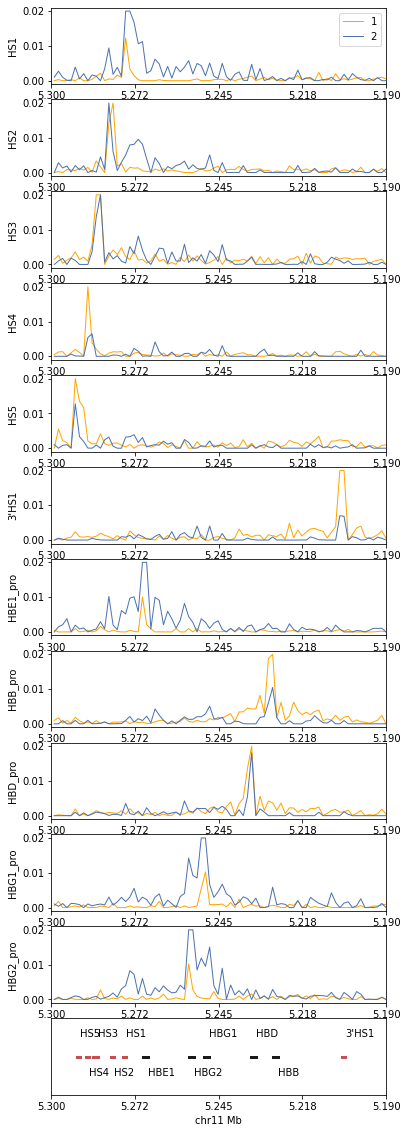

In [95]:
# 折线图
plt.figure(figsize=(6,20))
## 校正原件所在的bin
### HS5
Elementbins = {"HS1":[5275,5276],
               "HS2":[5280,5281],
               "HS3":[5284, 5285, 5286],
               "HS4": [5287, 5288],
               "HS5": [5290, 5291, 5292],
              "3'HS1":[5204,5205],
              "HBE1_pro":[5269,5270],
              "HBB_pro":[5227, 5228],
               "HBD_pro":[5234,5235],
              "HBG1_pro":[5249, 5250],
              "HBG2_pro":[5254, 5255] }

# HS Ancord df count
Clist = []
Axlist = []

axnum = 1
# get all reads
allbins = list( range( order_DF["bin"].min(),  order_DF["bin"].max()+1 ) )
freqmax = 0.02

for Elekey, selectbins in  Elementbins.items():
    if axnum > 1:
        Axlist.append( plt.subplot(12,1,axnum, sharex=Axlist[0]) )
    else:
        Axlist.append( plt.subplot(12,1,axnum) )
    
    merge_y = np.zeros( len(allbins) ) # merge all groups bincontact
    
    for cluster, group_DF in  order_DF.groupby("Cluster"):
        #selectbins =  bedDF.loc[bedDF.name.isin(select_ele), :].index.values
        #selectbins = [5284, 5285, 5286]
        # get select DF from group df
        select_reads = list( set( group_DF.loc[group_DF.bin.isin(selectbins) , "read_name"].to_list() ) )
        select_DF = group_DF.loc[group_DF.read_name.isin(select_reads), :]
        sCountdf = FragRatio(select_DF, allbins, Total_reads_num)
        readnum = len( select_reads )
        greadnum = len( group_DF.groupby("read_name")["start"].first() )# groub reads count
        #plt.plot(sCountdf.BinPos.values, sCountdf.Freq_ratio.values)
        #plt.plot(sCountdf.BinPos.values, sCountdf.Freq_ratio.values, c=colors[cluster], linewidth=2)
        Bin_x = sCountdf.BinPos.values 
        Bin_y = sCountdf.BinCount.values / greadnum
        merge_y  +=  sCountdf.BinCount.values # all groups
        Bin_x, Bin_y = smoothline(Bin_x, Bin_y, 80)
        # > freq_max  transform
        Bin_y[Bin_y >= freqmax] = freqmax
        plt.plot(Bin_x, Bin_y, c=colors[cluster], linewidth=1)
        Clist.append(cluster)
        
    # all group
    #Bin_x = sCountdf.BinPos.values
    #Bin_y = merge_y / len( order_DF.groupby("read_name")["start"].first() )
    #Bin_x, Bin_y = smoothline(Bin_x, Bin_y, 80)
    #plt.plot(Bin_x, Bin_y, c="k", linewidth=0.5)
    #Clist.append("ALL")
    if axnum == 1:
        plt.legend(Clist, loc='best')    
    plt.yticks([0, 0.01, 0.02])
    #plt.ylim([0, freqmax]) 
    #plt.yscale("log")
    plt.xticks([])
    plt.ylabel("%s"%(Elekey) )
    # axnum
    axnum += 1
    

# Gene Position
ax2 = plt.subplot(12,1,12, sharex=Axlist[0])
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    #xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    xs = [ gdf["start"], gdf["end"] ]
    if gdf["end"].values - gdf["start"].values <= 1000:
        xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize  ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])

Axlist[0].set_xticks([]) # set all xticks empty    
plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )
# 反转 x 轴
#plt.show()
w = Axlist[0].invert_xaxis()
ax2.set_xticks(Xtick)
ax2.set_xticklabels(Xtick_label)

plt.savefig("%s/K562_4C_Contact_%s_%d_%d.pdf"%(Exportdir, region[0], region[1], region[2]) )

math.floor(3/2)

In [96]:
#  Calculate frag ratio
def FragRatio(binDF, allbins, readnums):
    '''
    frag bin contact relative intensity
    '''
    Bincounts =  binDF.groupby("bin")["read_name"].count()
    #set up bin count dataframe
    Countdf = pd.DataFrame({"Bins": allbins,
                            "BinPos": [ b*binsize for b in allbins],
                           "BinCount": len(allbins)*[0] }, index =  allbins)
    # get bin count data
    Countdf.loc[Bincounts.index, "BinCount"] = Bincounts.values  
    Countdf = Countdf.sort_values("Bins", ignore_index=True)        
    Countdf.loc[:, "Freq_ratio"] = Countdf.BinCount.values / readnums
    return( Countdf )

def smoothline(x_array, y_array, smbins=100):
    '''
    smooth lines
    input: x,y array
    output: x, smooth_y array
    bigger smbins makes  
    '''
    xi = np.linspace(x_array.min(),x_array.max(),smbins)
    y_smooth =  make_interp_spline(x_array, y_array)(xi)
    y_smooth[y_smooth<=0.0] = 0.0 # 校正负数；
    return(xi, y_smooth)

In [97]:
# Bootstrap 
iterN = 100
sample_ratio = 0.3 # resample ratios
select_cols = ['read_name', 'bin', 'chrom', 'start', 'end', 'binfind', 'Cluster']

Boot_dict = {}
Boot_list = []
for cluster, gdf in order_DF.groupby("Cluster"):
    Creads = list( set(gdf.read_name.to_list()) ) ## Cluster reads
    Boot_dict[cluster] = []
    print("Resample Cluster %d ..."%cluster)
    for i in range(iterN):
        bootreads = resample( Creads, n_samples=math.ceil(sample_ratio*len(Creads) ) , replace=1 )
        bootdf = gdf.loc[gdf.read_name.isin(bootreads), select_cols]
        bootdf["Random"] = i
        Boot_dict[cluster].append(bootdf)
        Boot_list.append(bootdf)
        bootdf = None
        del(bootdf, bootreads)
    gc.collect()
        
## Merge   
Boot_df = pd.concat(Boot_list)
Boot_df.head()
## Exportfile
Exportfile = "%s/K562_Cluster_fragment_bootstrap.csv"%Exportdir
Boot_df.to_csv(Exportfile, header=True, index=False, sep="\t")

Resample Cluster 1 ...
Resample Cluster 2 ...


In [98]:
def Welch_Ttest(mean1, mean2, std1, std2, samplenum):
    '''
    Peform welch ttest of two cluster, using means, stds, and sample numbers
    '''
    modified_std1 = np.sqrt(np.float32(samplenum)/np.float32(samplenum-1)) * std1
    modified_std2 = np.sqrt(np.float32(samplenum)/np.float32(samplenum-1)) * std2
    
    (statistic, pvalue) = stats.ttest_ind_from_stats( mean1=mean1, std1=modified_std1, nobs1=samplenum, 
                                                     mean2=mean2, std2=modified_std2, nobs2=samplenum )
    #result = stats.ttest_ind(array1, array2, equal_var = False, alternative='two-sided')
    return(pvalue)




def PvalueColor(pvalue):
    '''
    Transform pvalue to color
    < 0.01 :  "r"
    0.05 ~ 0.01 : "salmon"
    >0.05 : "grey"
    '''
    if pvalue < 0.01:
        c = "r"
    elif pvalue > 0.05:
        c = "grey"
    elif pvalue >=0.01 and pvalue<=0.05:
        c = "grey"
    else:
        c = "grey"
    return(c)

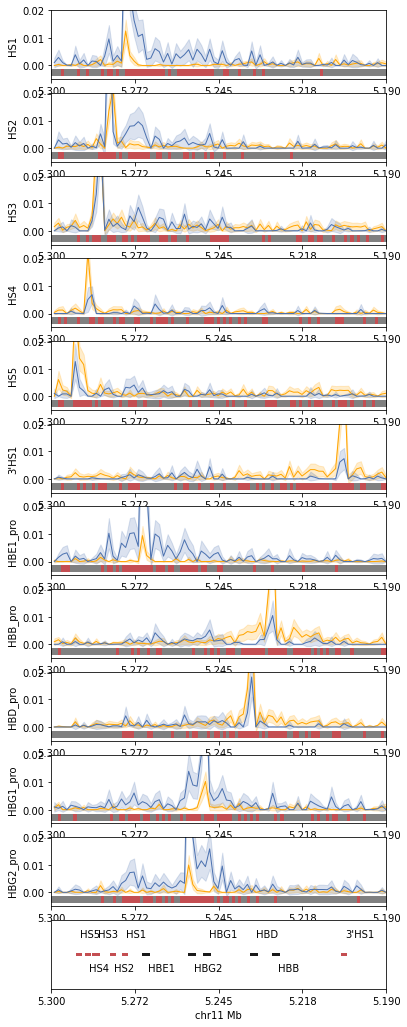

In [99]:
plt.figure(figsize=(6,18))
Elementbins = {"HS1":[5275,5276],
               "HS2":[5280,5281],
               "HS3":[5284, 5285, 5286],
               "HS4": [5287, 5288],
               "HS5": [5290, 5291, 5292],
              "3'HS1":[5204,5205],
              "HBE1_pro":[5269,5270],
              "HBB_pro":[5227, 5228],
               "HBD_pro":[5234,5235],
              "HBG1_pro":[5249, 5250],
              "HBG2_pro":[5254, 5255]}

# HS Ancord df count
Clist = []
Axlist = []
Freqlist = []


axnum = 1
# get all reads
allbins = list( range( order_DF["bin"].min(),  order_DF["bin"].max()+1 ) )

for Elekey, selectbins in  Elementbins.items():
    if axnum > 1:
        Axlist.append( plt.subplot(12,1,axnum, sharex=Axlist[0]) )
    else:
        Axlist.append( plt.subplot(12,1,axnum) )
    
    Merge_freq, Merge_std = {}, {} # Two group freq
    
    for cluster, group_DF in  order_DF.groupby("Cluster"):
        # get select DF from group df
        select_reads = list( set( group_DF.loc[group_DF.bin.isin(selectbins) , "read_name"].to_list() ) )
        
        # get bootstrap data
        dflist = Boot_dict[cluster] # get bootstrap datasets
        Resultlist = [] 
        for binDF in dflist:
            select_DF = binDF.loc[binDF.read_name.isin(select_reads), :]
            readnums = len( list( set( binDF.read_name.to_list() ) ) ) # random select sample reads
            Count_df = FragRatio(select_DF, allbins, readnums)
            Count_df["Cluster"] = cluster
            Resultlist.append(Count_df)
        FreqRatio_DF = pd.concat(Resultlist) # Merge and plot
        MeanRatio_df = FreqRatio_DF.groupby("BinPos")["Freq_ratio"].agg([('Mean_Ratio','mean'), ("Std", np.std)])
        MeanRatio_df = MeanRatio_df.reset_index()
        
        # smooth boot freq and plot
        Bin_raw_x = MeanRatio_df.BinPos.values
        Bin_raw_y = MeanRatio_df.Mean_Ratio.values
        Bin_raw_std = MeanRatio_df.Std.values # std
        Bin_x, Bin_y = smoothline(Bin_raw_x, Bin_raw_y, 80) #smooth
        Bin_x2, Bin_std = smoothline(Bin_raw_x, Bin_raw_std  , 80)
        plt.plot(Bin_x, Bin_y, '-', c=colors[cluster], linewidth=1, label='cluster%d'%(cluster) )
        plt.fill_between(Bin_x, Bin_y - Bin_std, Bin_y + Bin_std,  color=colors[cluster], alpha=0.2)
        Clist.append(cluster)
        
        # merge two group
        Merge_freq[cluster] =  Bin_raw_y 
        Merge_std[cluster] = Bin_raw_std 
    
    #  T test of two comparation
    Ckeys = list(Merge_freq.keys() )
    Merge_DF = pd.DataFrame({ "Bin_x" : Bin_raw_x, 
                            "Mean1":Merge_freq[Ckeys[0]],
                            "Mean2":Merge_freq[Ckeys[1]],
                             "Std1":Merge_freq[Ckeys[0]],
                            "Std2":Merge_freq[Ckeys[1]],
                             "nums":iterN } )
    std1 = Merge_DF.loc[Merge_DF.Std1>0, "Std1"].values.mean() # use mean std
    std2 = Merge_DF.loc[Merge_DF.Std2>0, "Std2"].values.mean() # use mean std
    #Merge_DF["p_value"] = Merge_DF.apply(lambda x:  Welch_Ttest(x["Mean1"], x["Mean2"], x["Std1"], x["Std2"], x["nums"]),  axis=1 )
    Merge_DF["p_value"] = Merge_DF.apply(lambda x:  Welch_Ttest(x["Mean1"], x["Mean2"], std1, std2, x["nums"]),  axis=1 )
    ## p_value adjust
    alpha = 0.01 # FDR 0.01
    rejected, p_adjusted, _, alpha_corrected = multipletests(Merge_DF["p_value"].values, alpha=alpha, 
                               method='bonferroni', is_sorted=False, returnsorted=False)
    Merge_DF["p_value_adj"] =  p_adjusted
    Merge_DF["color"] = Merge_DF["p_value_adj"].apply(lambda x: PvalueColor(x) )  # pvalue color
    
    ## p_value plot
    lineY = - 0.0025
    for n, rowvalue in Merge_DF.iterrows():
        x1, x2 = rowvalue["Bin_x"] - 0.5*binsize, rowvalue["Bin_x"] + 0.5*binsize
        c = rowvalue["color"]
        #plt.plot([x1,x2], [lineY, lineY], color=c, linestyle="-", linewidth=1)  
        plt.plot(rowvalue["Bin_x"], lineY, color=c, marker="s") 
    
    #plt.legend(Clist, loc='best')    
    #plt.xlim([region[1], region[2]])
    plt.ylim([lineY*2, 0.020]) 
    #plt.yscale("log")
    plt.xticks([])
    plt.ylabel("%s"%(Elekey) )
    # axnum
    axnum += 1
    
# Gene Position
ax2 = plt.subplot(12,1,12, sharex=Axlist[0])
nameP = -2.5
for name, gdf in bedDF.groupby("name"):
    if "HS" in name :
        sc = "r"
    else:
        sc = "k"
    #xs = [ gdf["start"], gdf["end"] ]
    binnum = gdf.index.values
    #xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize ]
    xs = [ gdf["start"], gdf["end"] ]
    if gdf["end"].values - gdf["start"].values <= 1000:
        xs = [ binnum*binsize-0.5*binsize, binnum*binsize+0.5*binsize  ]
    ys = [5, 5]
    plt.plot(xs, ys, c=sc, linewidth=3)
    nameP = nameP*-1
    plt.text(xs[0], 5+nameP,  name, fontsize=10)
plt.ylim([ 0, 10])
plt.yticks([])

plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
#plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )
ax2.set_xticks(Xtick)
ax2.set_xticklabels(Xtick_label)

# 反转 x 轴
w = Axlist[0].invert_xaxis()
#plt.show()
plt.savefig("%s/K562_4C_Contact_%s_%d_%d.pdf"%(Exportdir, region[0], region[1], region[2]) )

In [88]:
FreqRatio_DF

,Bins,BinPos,BinCount,Freq_ratio,Cluster
0,5190,5190000,0,0.0,3
1,5191,5191000,0,0.0,3
2,5192,5192000,0,0.0,3
3,5193,5193000,0,0.0,3
4,5194,5194000,0,0.0,3
...,...,...,...,...,...
105,5295,5295000,0,0.0,3
106,5296,5296000,0,0.0,3
107,5297,5297000,0,0.0,3
108,5298,5298000,0,0.0,3


In [252]:
Merge_DF

,Bin_x,Mean1,Mean2,Std1,Std2,nums,p_value,p_value_adj,color
0,5190000,0.000000,0.000000,0.000000,0.000000,100,1.000000,1.000000,grey
1,5191000,0.000597,0.001096,0.000597,0.000597,100,0.001665,0.183137,grey
2,5192000,0.000504,0.000000,0.000504,0.000504,100,0.001519,0.167094,grey
3,5193000,0.000000,0.000000,0.000000,0.000000,100,1.000000,1.000000,grey
4,5194000,0.000000,0.000000,0.000000,0.000000,100,1.000000,1.000000,grey
...,...,...,...,...,...,...,...,...,...
105,5295000,0.000000,0.000000,0.000000,0.000000,100,1.000000,1.000000,grey
106,5296000,0.000000,0.000000,0.000000,0.000000,100,1.000000,1.000000,grey
107,5297000,0.000000,0.000000,0.000000,0.000000,100,1.000000,1.000000,grey
108,5298000,0.000502,0.000743,0.000502,0.000502,100,0.125187,1.000000,grey


In [213]:
Ckeys[1]



2

In [192]:
FreqRatio_DF

,Bins,BinPos,BinCount,Freq_ratio,Cluster
0,5190,5190000,0,0.0,2
1,5191,5191000,0,0.0,2
2,5192,5192000,0,0.0,2
3,5193,5193000,0,0.0,2
4,5194,5194000,0,0.0,2
...,...,...,...,...,...
105,5295,5295000,0,0.0,2
106,5296,5296000,0,0.0,2
107,5297,5297000,0,0.0,2
108,5298,5298000,0,0.0,2


In [162]:
Resultlist = [] 
for clusterkey, dflist in Boot_dict.items():
    for binDF in dflist:
        readnums = len( list( set( binDF.read_name.to_list() ) ) ) # random select sample reads
        Count_df = FragRatio(binDF, allbins, readnums)
        Count_df["Cluster"] = clusterkey
        Resultlist.append(Count_df)
FreqRatio_DF = pd.concat(Resultlist) # Merge and plot

                                 read_name   bin  chrom    start      end  \
0     879572e0-35ec-4cf8-b0a5-91015d4700aa  5204  chr11  5203951  5204314   
1     879572e0-35ec-4cf8-b0a5-91015d4700aa  5210  chr11  5208508  5212123   
2     879572e0-35ec-4cf8-b0a5-91015d4700aa  5218  chr11  5217370  5218820   
3     879572e0-35ec-4cf8-b0a5-91015d4700aa  5231  chr11  5231382  5231450   
4     879572e0-35ec-4cf8-b0a5-91015d4700aa  5238  chr11  5238258  5238780   
...                                    ...   ...    ...      ...      ...   
5511  0af2b7f7-0eac-49ca-8f8e-94353ebb79aa  5213  chr11  5213299  5213835   
5512  0af2b7f7-0eac-49ca-8f8e-94353ebb79aa  5243  chr11  5243564  5244389   
5513  2befe41a-5bab-4913-83e7-8feb1316c9a8  5213  chr11  5213302  5213818   
5514  2befe41a-5bab-4913-83e7-8feb1316c9a8  5216  chr11  5216694  5216995   
5515  2befe41a-5bab-4913-83e7-8feb1316c9a8  5243  chr11  5242718  5243570   

      binfind  Cluster  Random  
0           1        1       0  
1        

In [304]:
def FindMultiContacts( TargetElements, gdf ):
    '''
    Find multi target contact reads in gdf
    '''
    gread_num = len( gdf.read_name.to_list() )
    # calculate target in each read
    match_reads = []
    for read_name, rdf in gdf.groupby("read_name"):
        bins = rdf.bin.to_list()
        Matchlist = []
        for key in TargetElements:
            targetbin = Elementbins[key]
            binmatch = len( set(bins).intersection( set(targetbin) ) )
            Matchlist.append(binmatch)
        
        if 0 not in Matchlist: # all match
            match_reads.append(read_name)
    match_num = len(match_reads)
    match_ratio =  match_num / gread_num
    return( match_num, match_ratio )


In [353]:
Elementbins = {"HS1":[5275,5276],
               "HS2":[5280,5281],
               "HS3":[5284, 5285, 5286],
               "HS4": [5287, 5288],
               "HS5": [5290, 5291, 5292],
              "3'HS1":[5204,5205],
              "HBE1_pro":[5269,5270],
              "HBB_pro":[5227, 5228],
               "HBD_pro":[5234,5235],
              "HBG1_pro":[5249, 5250],
              "HBG2_pro":[5254, 5255],
              "HS1/HS2":[5275,5276, 5280,5281],
              "HBG1/HBG2_pro":[5249, 5250, 5254, 5255],
              "HS1/HS3/HS5":[5275,5276,5284, 5285, 5286,5290, 5291, 5292] }

Ratio          count     mean       std  min      25%       50%       75%       max
cluster                                                                      
1        100.0  0.00000  0.000000  0.0  0.00000  0.000000  0.000000  0.000000
2        100.0  0.00198  0.001381  0.0  0.00138  0.001433  0.002837  0.005602
Count          count  mean       std  min  25%  50%  75%  max
cluster                                                
1        100.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0
2        100.0  1.41  0.985706  0.0  1.0  1.0  2.0  4.0


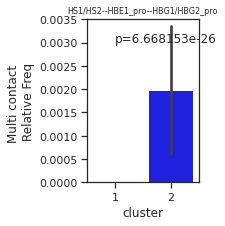

In [362]:
TargetElements = ["HS1/HS2", "HBE1_pro", "HBG1/HBG2_pro"]

Randomlist, Cluster, Matchlist, Match_ratio_list = [], [],[],[]
for (n, cluster), gdf in Boot_df.groupby(["Random", "Cluster"]):
    Randomlist.append(n)
    Cluster.append(cluster)
    match_num, match_ratio = FindMultiContacts(TargetElements, gdf )
    Matchlist.append(match_num)
    Match_ratio_list.append(match_ratio)
    
Match_df = pd.DataFrame({"Random":Randomlist,
                         "cluster":Cluster,
                         "Match_num":Matchlist,
                        "Relative_freq":Match_ratio_list})

print("Ratio", Match_df.groupby("cluster")["Relative_freq"].describe() )
print( "Count", Match_df.groupby("cluster")["Match_num"].describe() )

# bar plot
plt.figure(figsize=(2,3) )
sns.barplot(x="cluster", y="Relative_freq",data=Match_df,
            ci="sd", palette=["orange", "blue"])
# pvalue
Ttest = stats.ttest_ind(Match_df.loc[Match_df.cluster==1, "Relative_freq"].values,
                        Match_df.loc[Match_df.cluster==2, "Relative_freq"].values, 
                        equal_var = False, alternative='two-sided')
plt.ylim([0, 0.0035])
plt.title("--".join(TargetElements),  size=8  )
plt.ylabel("Multi contact \nRelative Freq")
plt.text(0,0.003, "p=%e"%Ttest.pvalue)
plt.savefig("K562_Multicontact_freq_1.pdf" )

Ratio          count      mean       std  min  25%       50%      75%       max
cluster                                                                  
1        100.0  0.000000  0.000000  0.0  0.0  0.000000  0.00000  0.000000
2        100.0  0.001004  0.001011  0.0  0.0  0.001374  0.00145  0.003026
Count          count  mean      std  min  25%  50%  75%  max
cluster                                               
1        100.0  0.00  0.00000  0.0  0.0  0.0  0.0  0.0
2        100.0  0.71  0.71485  0.0  0.0  1.0  1.0  2.0


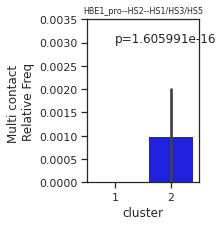

In [364]:
TargetElements = ["HBE1_pro","HS2", "HS1/HS3/HS5"]

Randomlist, Cluster, Matchlist, Match_ratio_list = [], [],[],[]
for (n, cluster), gdf in Boot_df.groupby(["Random", "Cluster"]):
    Randomlist.append(n)
    Cluster.append(cluster)
    match_num, match_ratio = FindMultiContacts(TargetElements, gdf )
    Matchlist.append(match_num)
    Match_ratio_list.append(match_ratio)
    
Match_df = pd.DataFrame({"Random":Randomlist,
                         "cluster":Cluster,
                         "Match_num":Matchlist,
                        "Relative_freq":Match_ratio_list})

print("Ratio", Match_df.groupby("cluster")["Relative_freq"].describe() )
print( "Count", Match_df.groupby("cluster")["Match_num"].describe() )

# bar plot
plt.figure(figsize=(2,3) )
sns.barplot(x="cluster", y="Relative_freq",data=Match_df,
            ci="sd", palette=["orange", "blue"])
# pvalue
Ttest = stats.ttest_ind(Match_df.loc[Match_df.cluster==1, "Relative_freq"].values,
                        Match_df.loc[Match_df.cluster==2, "Relative_freq"].values, 
                        equal_var = False, alternative='two-sided')
plt.ylim([0, 0.0035])
plt.title("--".join(TargetElements),  size=8  )
plt.ylabel("Multi contact \nRelative Freq")
plt.text(0,0.003, "p=%e"%Ttest.pvalue)
plt.savefig("K562_Multicontact_freq_2.pdf" )